In [1]:
%matplotlib notebook

import numpy as np

# Synthetic Data (4 Layers, 10 Time Steps)

In [3]:
from multidynet.datasets import simple_dynamic_multilayer_network
from multidynet.plots import plot_network

lmbda = np.array([[1., 1.],
                  [0.5, -0.5],
                  [-2.0, 2.0],
                  [-1., -1.]])

Y, X, lmbda, delta, probas = simple_dynamic_multilayer_network(
    n_nodes=100, n_time_steps=10,
    tau_sq=4.0, sigma_sq=0.1,
    lmbda=lmbda, 
    assortative_reference=False,
    random_state=33)

## Layer 1

<IPython.core.display.Javascript object>


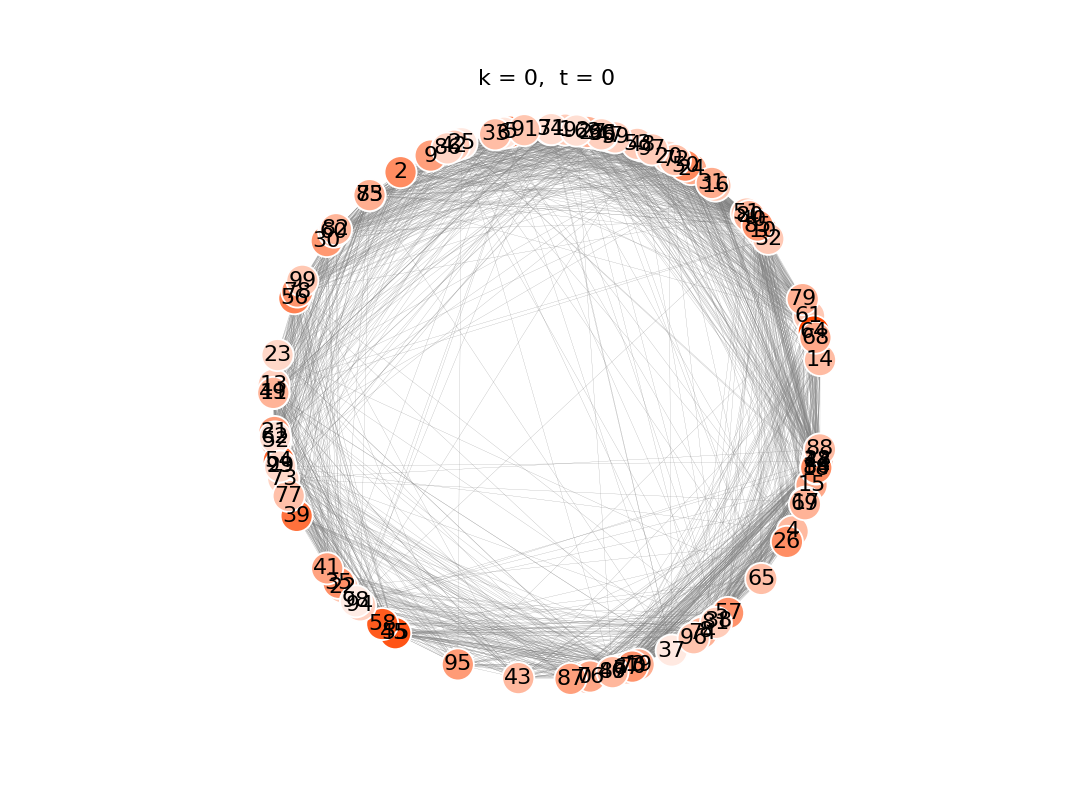

Text(0.5, 1.0, 'k = 0,  t = 0')

In [75]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 2

<IPython.core.display.Javascript object>


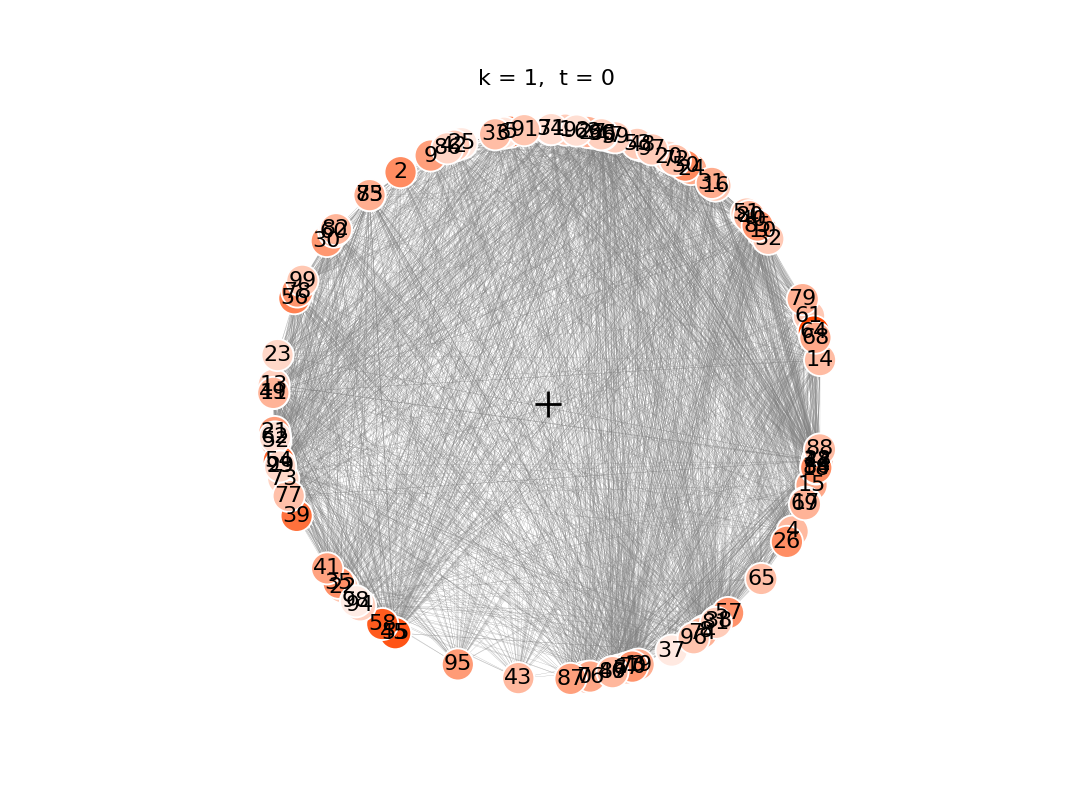

Text(0.5, 1.0, 'k = 1,  t = 0')

In [4]:
t = 0
k = 1

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 3

<IPython.core.display.Javascript object>


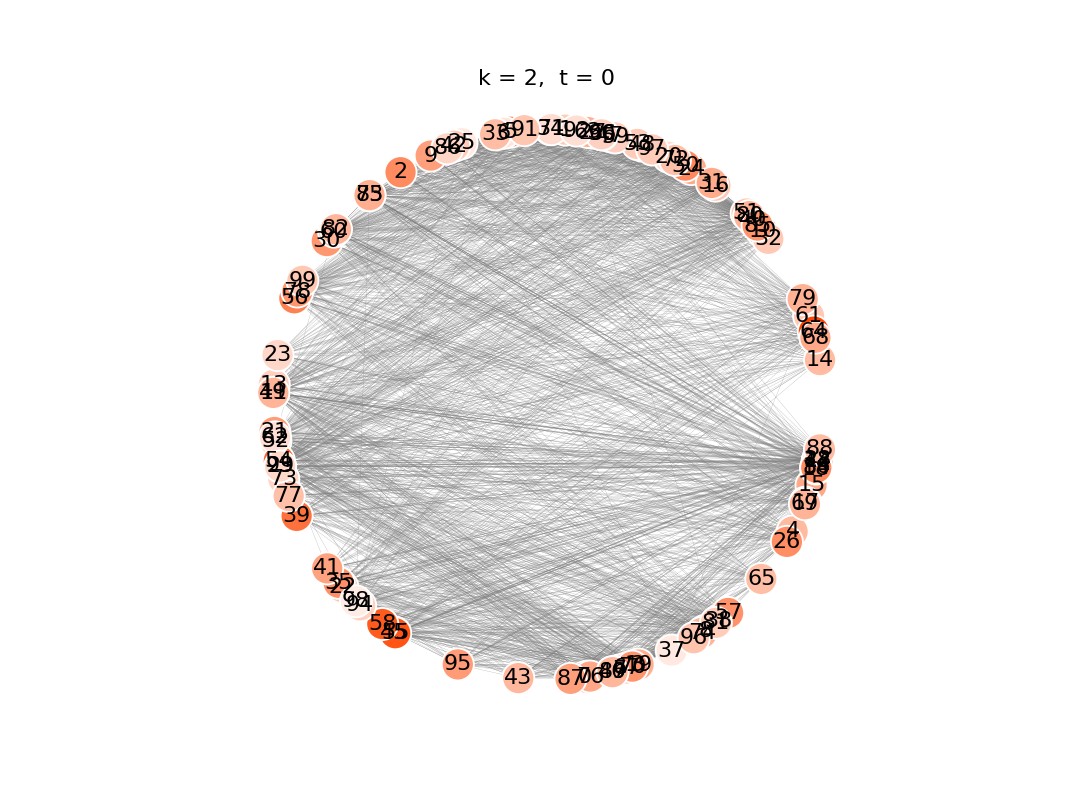

Text(0.5, 1.0, 'k = 2,  t = 0')

In [77]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 4

<IPython.core.display.Javascript object>


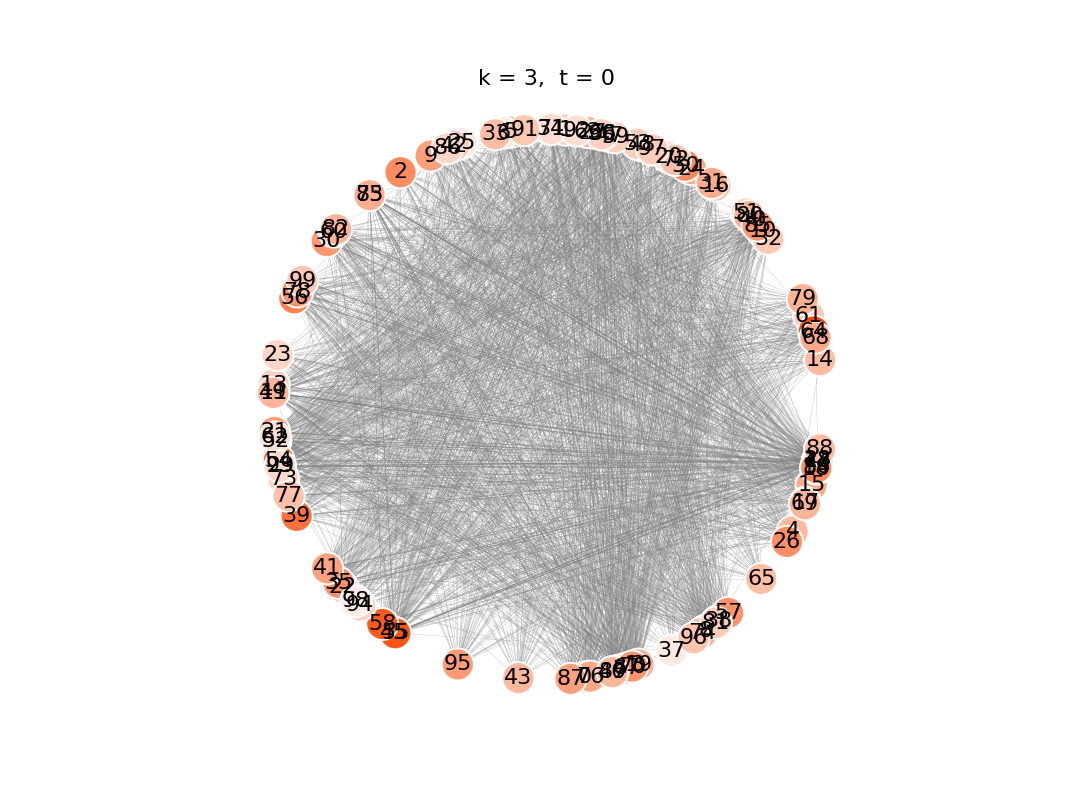

Text(0.5, 1.0, 'k = 3,  t = 0')

In [78]:
t = 0
k = 3

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

# Model Estimation

In [3]:
from multidynet import DynamicMultilayerNetworkLSM
from multidynet.model_selection import train_test_split

# Hold-out 10% of dyads for testing
Y_train, test_indices = train_test_split(Y, test_size=0.2)

model = DynamicMultilayerNetworkLSM(max_iter=500, 
                                    #a=4.0, b=20.0, c=10, d=0.1, 
                                    lambda_var_prior=10., 
                                    lambda_odds_prior=2,
                                    delta_var_prior=10.,
                                    #tol=1e-2,
                                    n_jobs=-1,
                                    n_init=8,
                                    random_state=123)
model.fit(Y_train)

<IPython.core.display.Javascript object>


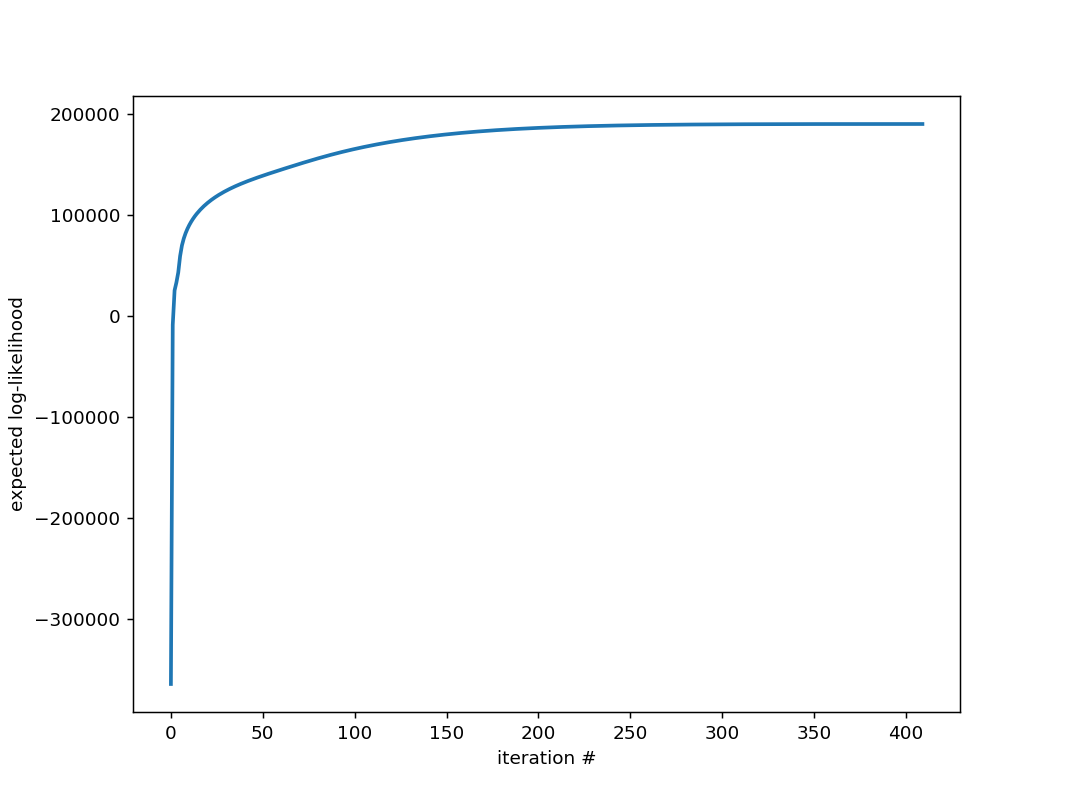

Text(0.5, 0, 'iteration #')

In [4]:
fig, ax= plt.subplots(figsize=(8, 6))
ax.plot(model.logp_, lw=2)
ax.set_ylabel('expected log-likelihood')
ax.set_xlabel('iteration #')

# Parameter Estimates

# Assortativity Parameters $\Lambda_k$

In [5]:
model.lambda_

array([[ 1.        ,  1.        ],
       [-0.49675491,  0.50467532],
       [ 1.84278488, -1.84801728],
       [-0.95173968, -0.96100284]])

# Sociability Parameters $\delta_k^i$

In [6]:
np.mean((model.delta_ - delta) ** 2)

0.023162543636600336

# $\tau^2$

In [7]:
model.tau_sq_

4.189247596540537

# $\sigma^2$

In [8]:
model.sigma_sq_

0.0602297540189948

## Latent Space 

<IPython.core.display.Javascript object>


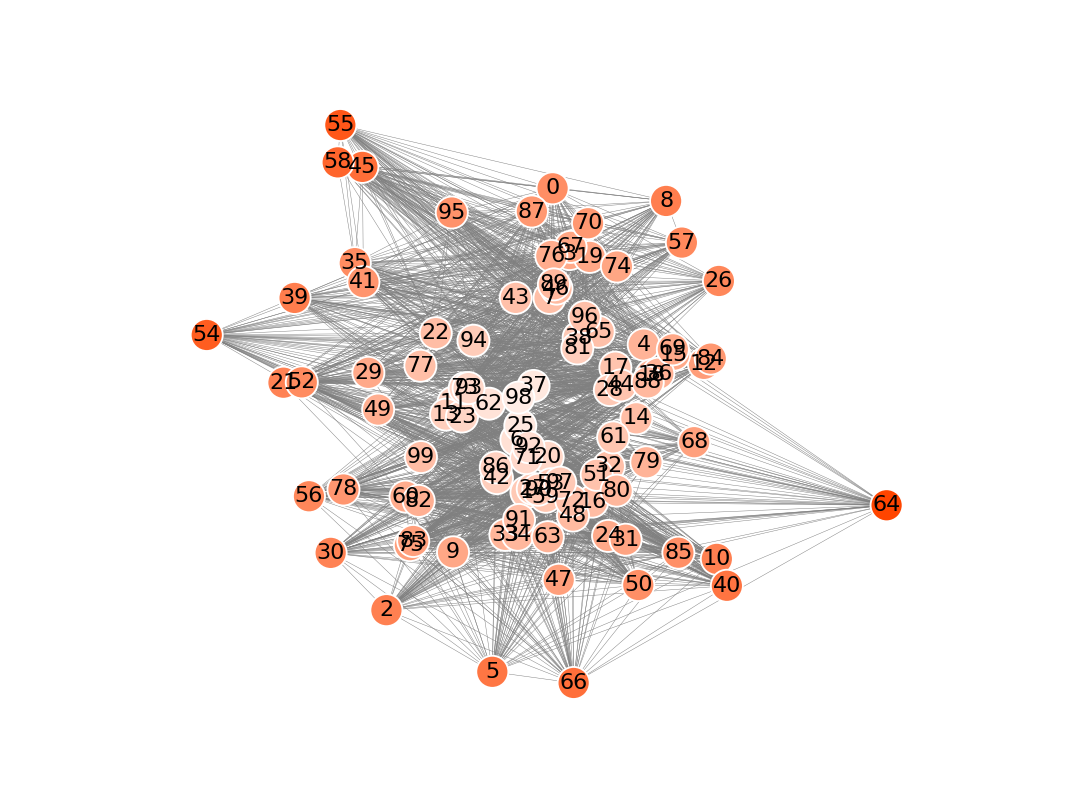

In [96]:
from multidynet.plots import plot_network

t = 0
k = 2
ax = plot_network(Y[k, t],model.X_[t], normalize=False, with_labels=True)

# Performance Diagnostics

## In-sample AUC

In [88]:
model.auc_

0.9614238556715579

## Held-out AUC

In [89]:
from multidynet.metrics import calculate_auc

calculate_auc(Y, model.probas_, test_indices)

0.9593999719621653

## Connection Probability Estimates

<IPython.core.display.Javascript object>


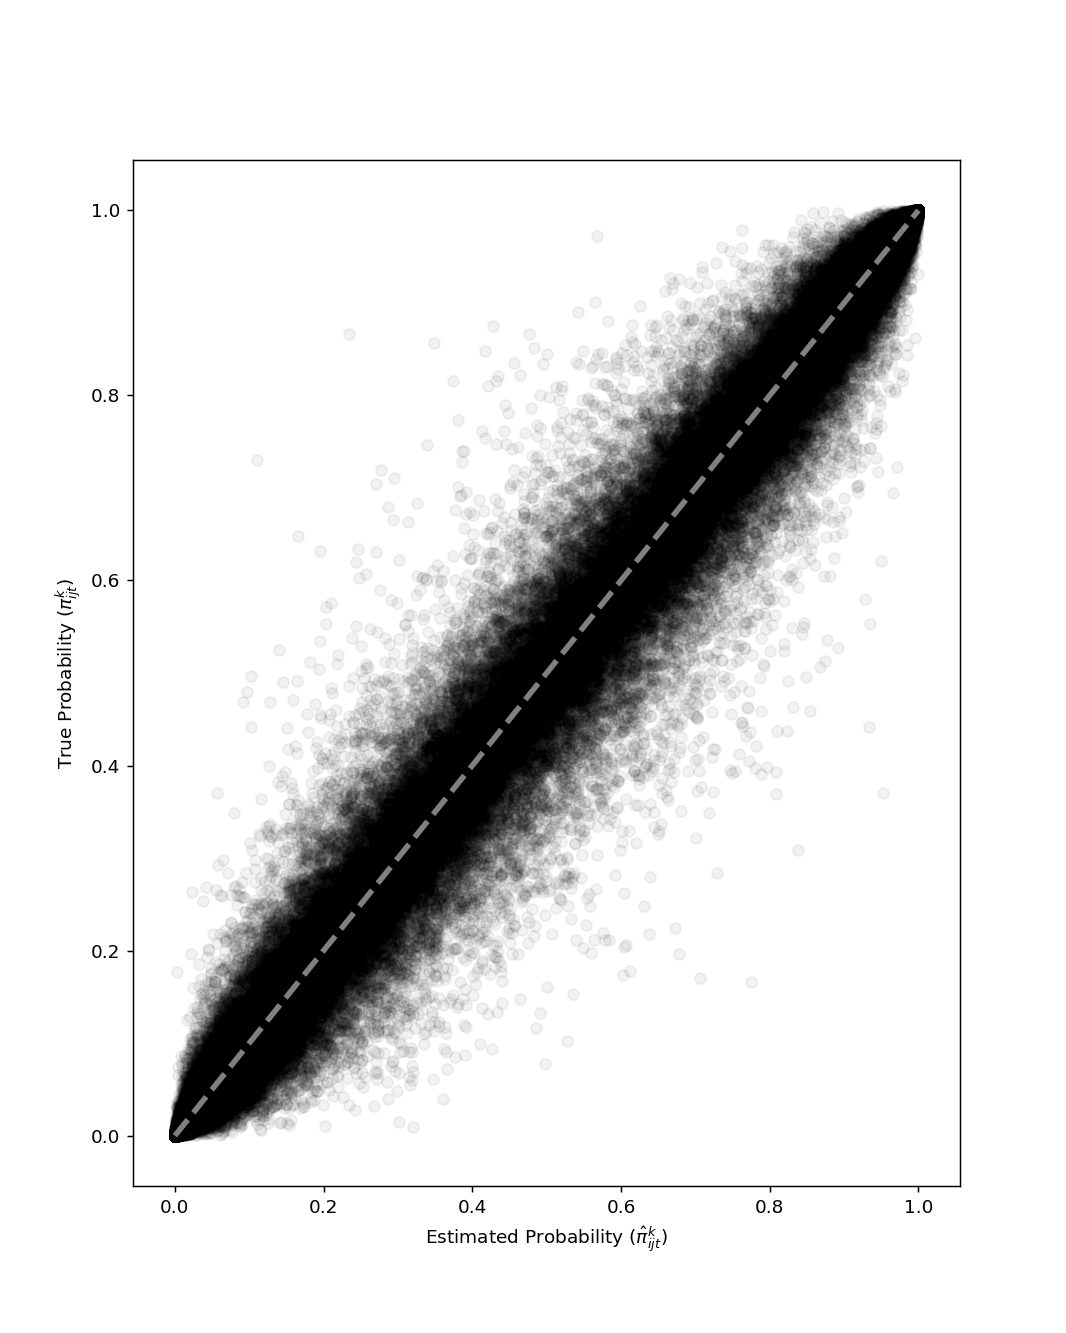

Text(0.5, 0, 'Estimated Probability ($\\hat{\\pi}_{ijt}^k$)')

In [90]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))

p_true = np.zeros((n_layers, n_time_steps, n_dists))
p_est = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = model.probas_[k, t]
        
        deltak = delta[k].reshape(-1, 1)
        d_true = expit(np.add(deltak, deltak.T)+ np.dot(X[t] * lmbda[k], X[t].T))

        indices = np.tril_indices_from(d_est, k=-1)
        p_true[k, t] = d_true[indices]
        p_est[k, t] = d_est[indices]

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, '--', color='gray', lw=3)
ax.scatter(p_est.ravel(), p_true.ravel(), alpha=0.05, c='k')
ax.set_ylabel('True Probability ($\pi_{ijt}^k$)')
ax.set_xlabel('Estimated Probability ($\hat{\pi}_{ijt}^k$)')

In [10]:
import pickle

pickle.dump(model, open('model_types_n100_t10.pkl', 'wb'))

In [4]:
import pickle

model = pickle.load(open('model_types_n100_t10.pkl', 'rb'))

In [7]:
from multidynet.metrics import score_latent_space

mse, perm = score_latent_space(X, model.X_)

In [91]:
import itertools

def calculate_mse(X_true, X_pred):
    """Try all column permutations and feature flipping combinations to 
    determine the MSE of the estimate"""
    n_features = X_true.shape[2]
    best_mse = np.inf
    best_perm = None
    for perm in itertools.permutations(np.arange(n_features)):
        X = X_pred[..., perm]
        
        # loops through single feature flips
        for p in range(n_features):
            Xp = X.copy()
            Xp[..., p] = -X[..., p]
            mse = np.mean((X_true - Xp) ** 2)
            if mse < best_mse:
                best_mse = mse
                best_perm = perm
                
        # loop through all feature combinations
        for k in range(2, n_features + 1):
            for combo in itertools.combinations(range(n_features), k):
                Xp = X.copy()
                Xp[..., combo] = -X[..., combo]
                mse = np.mean((X_true - Xp) ** 2)
                if mse < best_mse:
                    best_mse = mse
                    best_perm = perm
    
    return best_mse, best_perm
    
calculate_mse(X, model.X_)

(0.03124561770106972, (1, 0))

In [8]:
np.mean((lmbda - model.lambda_[..., perm]) ** 2)

0.006462195818843261

In [9]:
np.mean((delta - model.delta_)**2)

0.023162543636600336

In [11]:
np.mean((model.probas_ - probas) ** 2)

0.001778819296802132

In [12]:
model.covnerged_

AttributeError: 'DynamicMultilayerNetworkLSM' object has no attribute 'covnerged_'

In [13]:
model.converged_


AttributeError: 'DynamicMultilayerNetworkLSM' object has no attribute 'converged_'